In [119]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [120]:
# using the SQLite Table to read data.
con = sqlite3.connect('dataset/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [121]:
filtered_data['Score'].value_counts() #Data points in each class

positive    443777
negative     82037
Name: Score, dtype: int64

In [122]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [123]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [124]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [125]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [126]:
#taking 1k positive reviews
positive_reviews = final.loc[final["Score"]=='positive']
positive_reviews=positive_reviews.sample(1000)

In [127]:
##taking 1k positive reviews
negative_reviews = final.loc[final["Score"]=='negative']
negative_reviews=negative_reviews.sample(1000)

In [128]:
print(positive_reviews.shape)
print(negative_reviews.shape)

(1000, 10)
(1000, 10)


In [129]:
#dropping the final dataframe for storing the 2k reviews
final.drop(final.index, inplace=True)

In [130]:
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [131]:
#appending the 1k positive and 1k negative reviews to final dataframe
final = final.append(positive_reviews)
final = final.append(negative_reviews)

In [133]:
final.shape

(2000, 10)

In [134]:
final['Score'].value_counts()

positive    1000
negative    1000
Name: Score, dtype: int64

# Text Processing

In [135]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [136]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [139]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
466298,504159,B004IRCHQG,AEZXJJRGGWVA7,"S. S. Russell ""Reeses30135""",0,0,positive,1318464000,One of the better K Cups!,This is one of my favorites to use with my Keu...,one favorit use keurig sinc fan bold bitter co...
166577,180616,B000CQBZQK,A1DTWKFY5VBGJU,S. Rozycki,0,0,positive,1179360000,"Really good, for decaf",I'd received a sample of Stash's English Break...,receiv sampl stash english breakfast decaf pre...
487630,527303,B002LL8Q2K,A2DS23E19TQVQ6,Tabeeeeeeetha,1,1,positive,1326326400,Love love love love love these.,"I can finish a pack of these in one sitting, e...",finish pack one sit easili especi eat watch ab...


In [140]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# BOW

In [141]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 6401)


In [142]:
final_counts= final_counts.todense()

In [143]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_counts)
print(standardized_data.shape)

(2000, 6401)


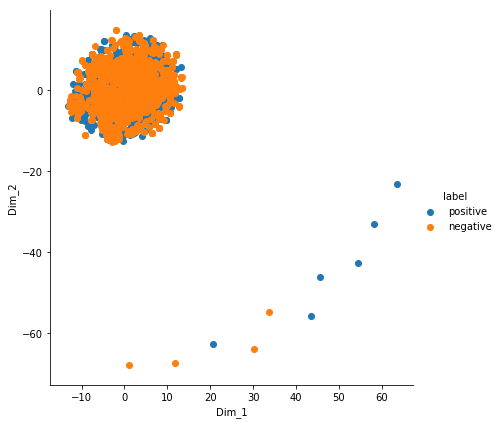

In [144]:
from sklearn.manifold import TSNE

labels = final['Score'] #storing label i.e positive and negative in another variable for tsne plot
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [151]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 64345)
the number of unique words including both unigrams and bigrams  64345


In [152]:
final_counts = final_bigram_counts

In [153]:
final_counts= final_counts.todense()

In [154]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_counts)
print(standardized_data.shape)

(2000, 64345)


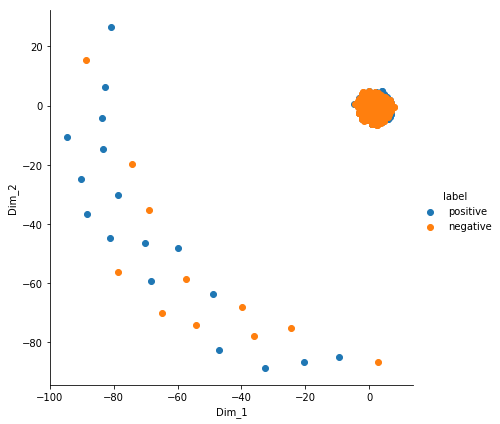

In [155]:
#TSNE BOW bi,tri,ngram
model = TSNE(n_components=2, random_state=0, perplexity =25, n_iter = 5000)

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

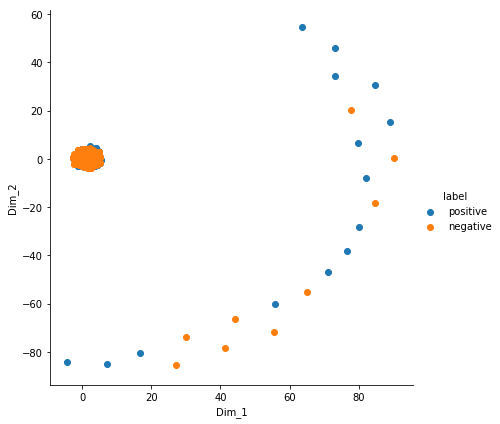

In [156]:

model = TSNE(n_components=2, random_state=0, perplexity =50, n_iter = 5000)

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF

In [94]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 87026)
the number of unique words including both unigrams and bigrams  87026


In [95]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1500:1510])

some sample features(unique words in the corpus) ['account', 'account and', 'account don', 'account for', 'account the', 'accounts', 'accounts in', 'accurate', 'accurate appraisal', 'accurate that']


In [96]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [97]:
top_tfidf

,feature,tfidf
0,zombie,0.402114
1,zombie energy,0.201057
2,decoration,0.201057
3,don plan,0.201057
4,decoration for,0.201057
5,be decoration,0.201057
6,zombie fan,0.201057
7,desk great,0.201057
8,work desk,0.201057
9,this zombie,0.201057


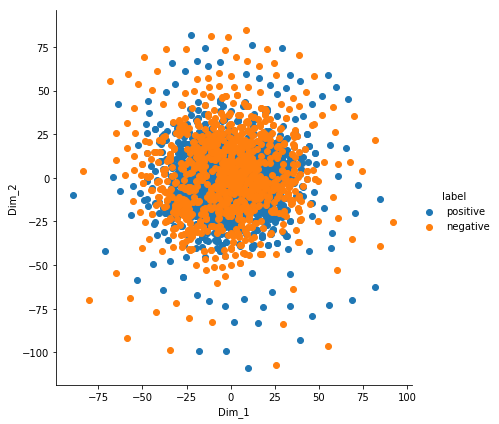

In [34]:
# TSNE

from sklearn.manifold import TSNE

labels = final['Score']
final_tf_idf = final_tf_idf.todense()

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_tf_idf)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

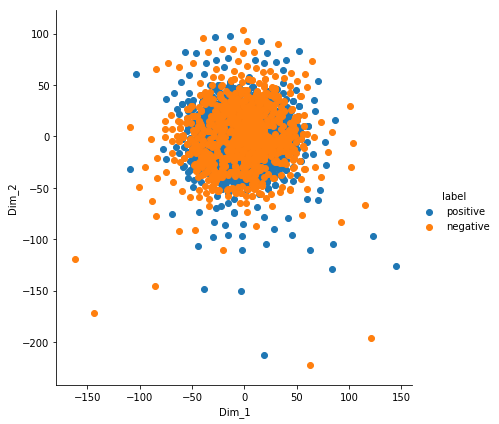

In [35]:
model = TSNE(n_components=2, random_state=0, perplexity =30, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_tf_idf)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

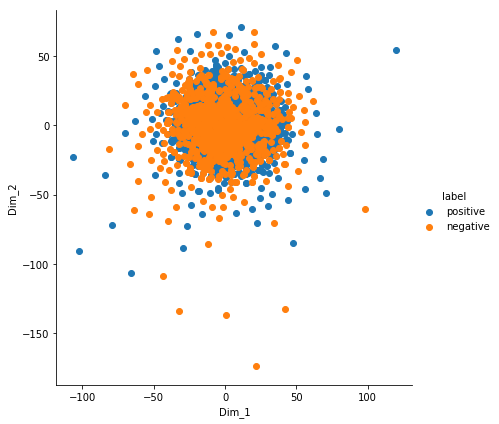

In [36]:
model = TSNE(n_components=2, random_state=0, perplexity =50, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_tf_idf)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# AVG-W2VEC

In [82]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [83]:
print(final['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

If you eat instant ramen and like spicy food, this is for you.  It's fairly cheap when on sale (I get the 30 pack for about $20 with subscribe and save plus a coupon), and lasts years.  Also, this product is made in America, so you don't have to worry about finding things that aren't food in your food.<br /><br />For instant ramen lovers who like spicy food, I give this five stars.
*****************************************************************
['if', 'you', 'eat', 'instant', 'ramen', 'and', 'like', 'spicy', 'food', 'this', 'is', 'for', 'you', 'its', 'fairly', 'cheap', 'when', 'on', 'sale', 'i', 'get', 'the', 'pack', 'for', 'about', 'with', 'subscribe', 'and', 'save', 'plus', 'a', 'coupon', 'and', 'lasts', 'years', 'also', 'this', 'product', 'is', 'made', 'in', 'america', 'so', 'you', 'dont', 'have', 'to', 'worry', 'about', 'finding', 'things', 'that', 'arent', 'food', 'in', 'your', 'food', 'for', 'instant', 'ramen', 'lovers', 'who', 'like', 'spicy', 'food', 'i', 'give', 'this', 'fiv

In [84]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [87]:
words = list(w2v_model.wv.vocab)
print(len(words))

2596


In [88]:
w2v_model.wv.most_similar('good')

[('taste', 0.9951882362365723),
 ('great', 0.9949905276298523),
 ('as', 0.9946457743644714),
 ('its', 0.994600772857666),
 ('tastes', 0.993267297744751),
 ('very', 0.9922217130661011),
 ('sweet', 0.9919861555099487),
 ('strong', 0.9918805360794067),
 ('too', 0.9913867712020874),
 ('bitter', 0.9912457466125488)]

In [89]:
w2v_model.wv.most_similar('like')

[('but', 0.9959600567817688),
 ('really', 0.9943572282791138),
 ('much', 0.9937105774879456),
 ('bad', 0.9930117130279541),
 ('worth', 0.9928197860717773),
 ('drink', 0.9927462339401245),
 ('too', 0.9926304817199707),
 ('just', 0.9924222826957703),
 ('ok', 0.992219090461731),
 ('way', 0.9919590353965759)]

In [90]:
w2v_model.wv.most_similar('tasty')

[('healthy', 0.999618411064148),
 ('also', 0.9993442296981812),
 ('hard', 0.9993138909339905),
 ('quite', 0.9992996454238892),
 ('ones', 0.9992222189903259),
 ('crackers', 0.999186098575592),
 ('terrible', 0.9991835355758667),
 ('nuts', 0.9991689920425415),
 ('salty', 0.9991353750228882),
 ('chips', 0.9991341233253479)]

In [91]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


In [92]:
df = pd.DataFrame(sent_vectors) # converting the sparse matrix to dataframe
df.isnull().any() # checking if there is any is null in dataframe

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [93]:
final_counts=df

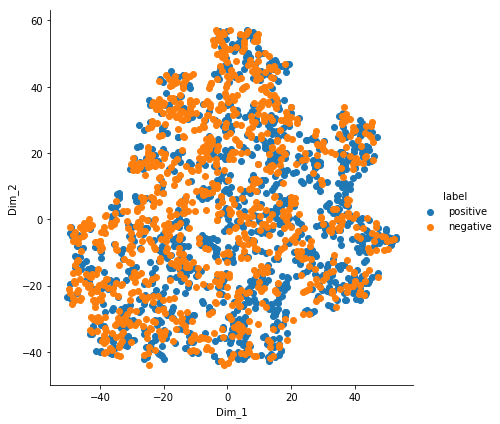

In [64]:
## TSNE FOR AVGW2VEC

from sklearn.manifold import TSNE

labels = final['Score'] #storing label i.e positive and negative in another variable for tsne plot
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

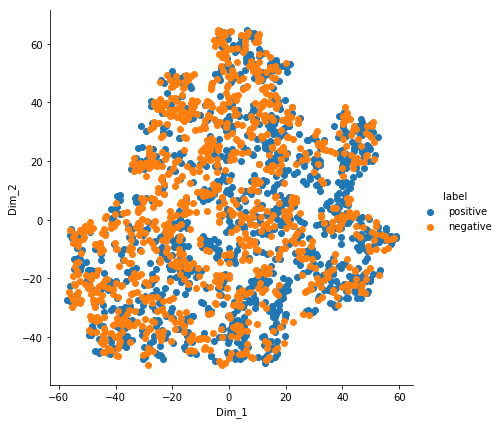

In [65]:
model = TSNE(n_components=2, random_state=0, perplexity =30, n_iter = 2500)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

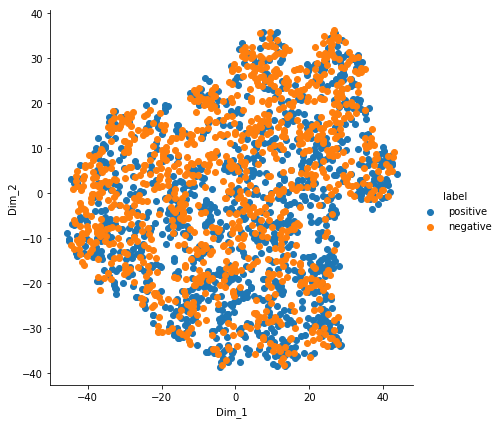

In [66]:
model = TSNE(n_components=2, random_state=0, perplexity =50, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

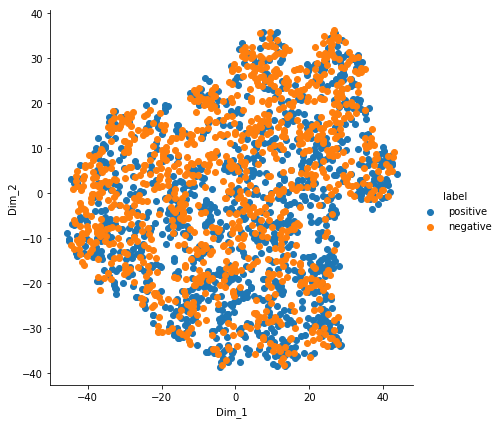

In [67]:
model = TSNE(n_components=2, random_state=0, perplexity =50, n_iter = 10000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TFIDF-W2VEC

In [80]:
# To avoid warnings 
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html
#np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [107]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [108]:
final_counts = tfidf_sent_vectors

In [110]:
len(final_counts)

2000

In [111]:
np.isnan(final_counts)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

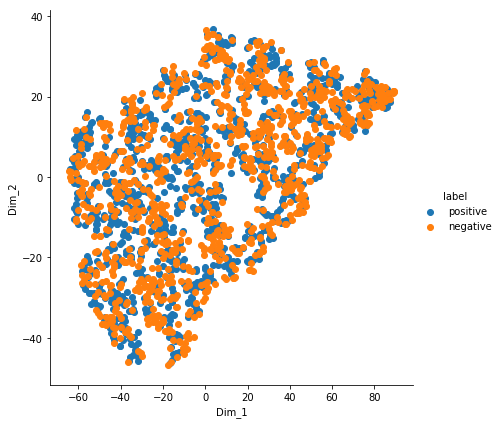

In [112]:
## TSNE FOR AVGW2VEC

from sklearn.manifold import TSNE

labels = final['Score'] #storing label i.e positive and negative in another variable for tsne plot
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

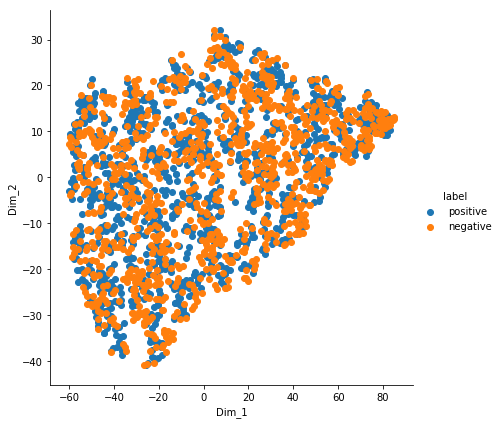

In [113]:
model = TSNE(n_components=2, random_state=0, perplexity =40, n_iter = 2000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

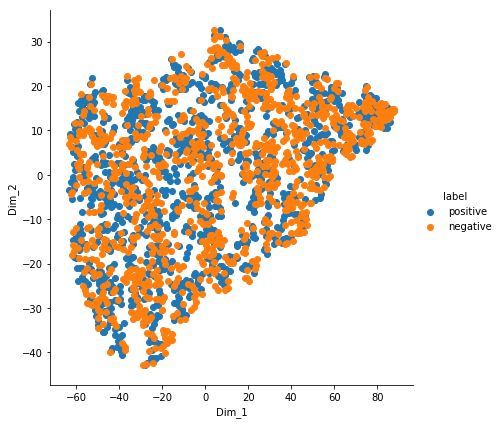

In [114]:
model = TSNE(n_components=2, random_state=0, perplexity =40, n_iter = 4000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

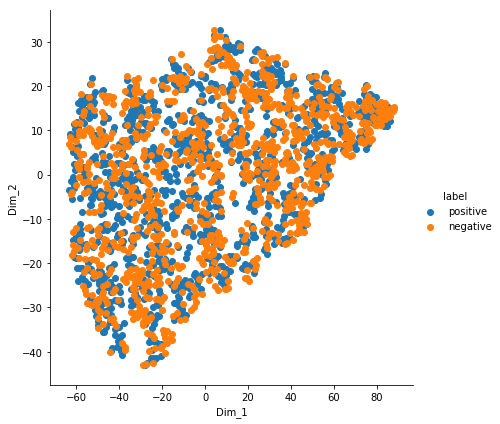

In [115]:
model = TSNE(n_components=2, random_state=0, perplexity =40, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

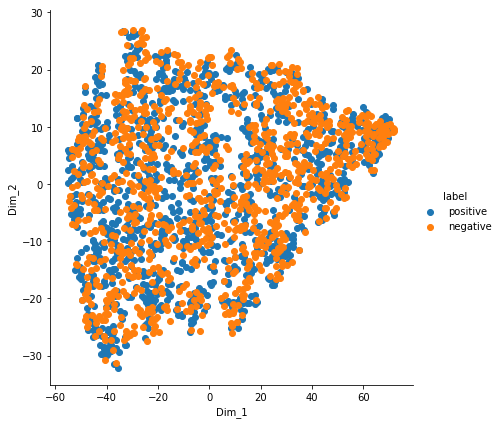

In [116]:
model = TSNE(n_components=2, random_state=0, perplexity =50, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

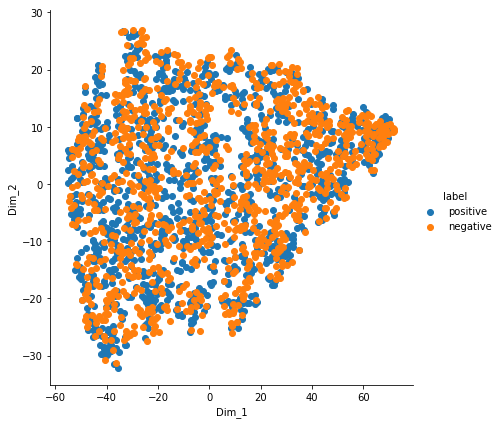

In [117]:
model = TSNE(n_components=2, random_state=0, perplexity =50, n_iter = 10000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# OBSERVATION

1) BOW T-SNE Plot - The two classes are overlapping and it cannot be separated using the BOW method.<br>
2) TF-IDF T-SNE Plot - The two classes are closely packed but it is somewhat better than the BOW tecnique, we can see the two classes but unfortunately we are unable to classify between the two classes<br>
3) Average W2VEC - Here the two classes are well spreaded over the graph but they the overlapping<br>
4) Weighted W2VEC - Here also the classes are well separated over the graph but unfortunately we cannot simple seperate the two classes<br>

# Conclusion

- As explained above we cannot simply draw a plane to seperate the positive and negative reviews, i is not possible
- None of the 4 plots are able to sepearte well the classes, by whihc they cn be differentiated